# Lab5 Clustering

This week's exercise will focus on clustering using two common algorithms, k-means and k-medoids

Schedule:
* Implement the core of k-means
* Clustering visualizations

In [1]:
# ! git pull

In [2]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

pd.options.mode.chained_assignment = None

# BEFORE YOU START: Classification vs Clustering
Most of this excercise, specially the first part, will be very similar to the Lab3 Classification. This is because classification and clustering are similar concepts, but with a very important difference:

- Classification assigns labels from a pre-existing set
- Clustering groups together data by similarity

While k-nearest-neighbors returned somethin meaningful like 'GP' (GoalKeeper) and such, clustering algorithms will return something like 'Group1' or 'ClusterA'.
While after classification the task of the data scientist is to understand if the classification is *correct*, after clustering they need to understand if the clusters are *meaningful*, and what meaning those could have.


## Take a look at the data (again)

In [3]:
# Check that data and data path is present
basedir = "../"
file = "fifa.csv"
assert os.path.isdir(f"{basedir}data") and os.path.exists(f"{basedir}data/{file}"), 'Data not found. Make sure to have the most recent version!'

data = pd.read_csv(f'{basedir}/data/fifa.csv', sep=",")

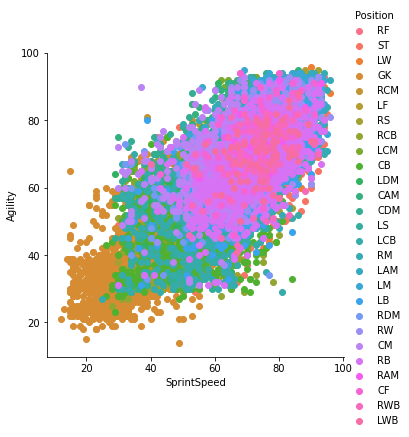

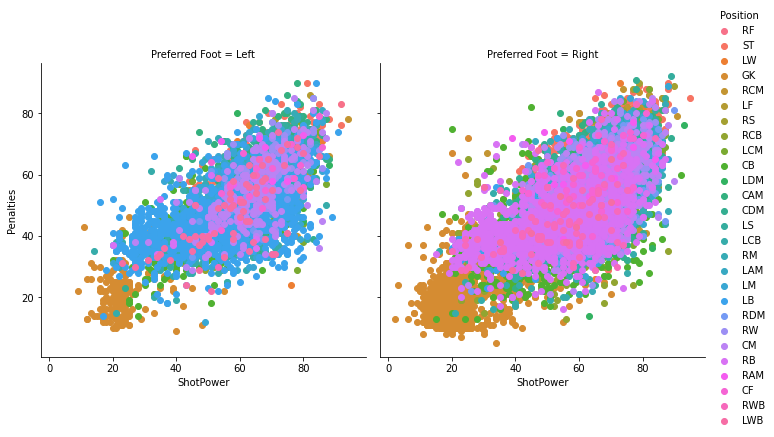

In [4]:
sns.FacetGrid(data, height=5,hue="Position").map(plt.scatter,"SprintSpeed","Agility").add_legend()
sns.FacetGrid(data, height=5,hue="Position", col='Preferred Foot').map(plt.scatter,"ShotPower",'Penalties').add_legend()

The scatter plots shows that the `Position` of a player could be related to some of their statistics. The dataset contains 30+ statistics and we don't know which ones will be most helpful, so we are picking an arbitrary subset to avoid the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).
It's also possible to choose the best ones [algorithmically](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Feature_extraction)

In [5]:
all_features = ['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing',
            'BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina',
            'Strength','LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure',
            'Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']

features = ["Aggression","Composure","Penalties",'SlidingTackle']
# cleaning: remove all the lines that contain a NaN in one of the feature columns
data = data.dropna(subset=features)

# K-means

0. pick a value for K (number of clusters)
1. standardize fields (Reminder: subtract by mean, then divide by standard deviation)
2. create K random centroids as arrays with size the number of features
3. foreach `datapoint` in `data`:
  1. set as `centroid` of `datapoint` the closest `centroid`
  2. if at least one `centroid` has changed: goto 3
  
### Tips
- the computations needed for k-means are expensive, test on a small subset of the data to save time (5/10 to check calculations on single rows, 50/100 to check the correctness of the whole algorithm)
- you'll need to compute a distance at a certain point, check Lab3
- [DataFrame.idxmin](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html]) will give you the index of the smallest entry in a dataset
- `dataFrame1 is dataFrame2` is not correct (it checks if the two objects are the same, not if they contain the same values). The correct approach is `dataFrame1.equals(dataFrame2)` (or `dataFrame1['aColumn'].equals(dataFrame2['aColumn'])` ;))
- You can apply a function to every element/row/column of a dataframe by using the `apply` pandas function
- To update the values of the centroids, you might find the combination of `groupby` and `mean` to be useful.
### Reminders:
- Euclidian Distance:
$$ d_e(a, b) = \sqrt{\sum_{i=1}^m{{(a_i-b_i)}^2}}$$
- Minkowski Distance:
$$ d_m(a, b) = \sqrt[q]{\sum_{i=1}^m{{\lvert a_i-b_i \rvert}^q}}$$
- Chebyshev Distance:
$$ d_c(a, b) = \max(\lvert a_1-b_1 \rvert, \lvert a_2-b_2 \rvert, ..., \lvert a_m-b_m \rvert)$$

In [6]:
# 0: define K
K = 5

In [7]:
# 1: Standardize features
data[features] = data[features].sub(data[features].mean(axis=0)).divide(data[features].std(axis=0))

In [8]:
def k_means_clustering(data, max_iter=-1):
    
    # Inizialize the centroids by sampling K elements from the data (do you remember the pandas sample function? :D)
    # Then, remember to reset the indeces of the new centroids dataframe without introducing new columns
    # (there's a pandas function for that as well :D)
    ## YOUR CODE HERE
    centroids = data[features].sample(K)
    centroids = centroids.reset_index(drop=True)
    
    # Implement the function assign_centroid that assigns the index of the closest centroid (Euclidian Distance)
    def assign_centroid_euclidian(x):
        ## YOUR CODE HERE
        x['Centroid'] = centroids.sub(x[features]) \
            .pow(2).sum(1).pow(0.5) \
            .idxmin(0)
        return x
    
    # Implement the function assign_centroid that assigns the index of the closest centroid (Minkowski Distance)
    q = 1 # e.g.: q=1 -> Manhattan Distance
    def assign_centroid_minkowski(x):
        ## YOUR CODE HERE
        x['Centroid'] = centroids.sub(x[features]) \
            .abs().pow(q).sum(1).pow(1/q) \
            .idxmin(0)
        return x
    
    # Implement the function assign_centroid that assigns the index of the closest centroid (Chebyshev Distance)
    def assign_centroid_chebyshev(x):
        ## YOUR CODE HERE
        x['Centroid'] = centroids.sub(x[features]) \
            .abs().max(1) \
            .idxmin(0)
        return x

    iter = 0
    data = data.assign(Centroid=pd.Series([-1] * len(data)), OldCentroid=pd.Series([0] * len(data)))

    # Implement the actual K-means loop:
    while not data['Centroid'].equals(data['OldCentroid']):
        ## YOUR CODE HERE
        print(f'iter {iter}')
        
        data['OldCentroid'] = data['Centroid']
        data = data.apply(assign_centroid_euclidian, axis=1)
        # data = data.apply(assign_centroid_minkowski, axis=1)
        # data = data.apply(assign_centroid_chebyshev, axis=1)
        centroids = data.groupby('Centroid').mean()[features]
        centroids.reset_index()
        
        iter += 1
        if max_iter > -1 and iter >= max_iter:
            break
    
    print('done')
    return data[features+['Centroid']], centroids


In [9]:
new_data, new_centroids = k_means_clustering(data.head(50))

iter 0
iter 1
iter 2
done


In [10]:
new_data

,Aggression,Composure,Penalties,SlidingTackle,Centroid
0,-0.453075,3.266115,1.684368,-0.923543,4
1,0.410584,3.178673,2.321146,-1.064460,4
2,0.007543,3.091231,2.066435,-0.594737,4
3,-1.028848,0.817735,-0.544356,-1.534183,0
4,1.159088,2.566578,1.939079,0.250765,3
5,-0.107611,2.828904,2.384824,-1.111432,4
6,0.353007,2.216809,2.130113,1.284156,1
7,1.792438,2.304251,2.321146,-0.359875,3
8,1.850016,2.041925,1.684368,2.129657,2
9,-1.259157,0.992619,-2.391013,-1.299322,0


In [11]:
new_centroids

,Aggression,Composure,Penalties,SlidingTackle
Centroid,,,,
0,-1.342324,0.837167,-1.251888,-1.497649
1,0.655287,2.457275,1.748046,1.354614
2,1.672049,2.129367,0.538167,1.911877
3,1.118784,2.339228,2.123745,-0.308206
4,-0.114809,2.626694,1.700287,-0.811984


# Clusters visualization
The most difficult task with clustering is understand if the clustering makes sense and what the clustering means. If the dimensionality is low, a good idea is to use a pairplot and see if the clusters are really close in each slice. The closer they are, the better.

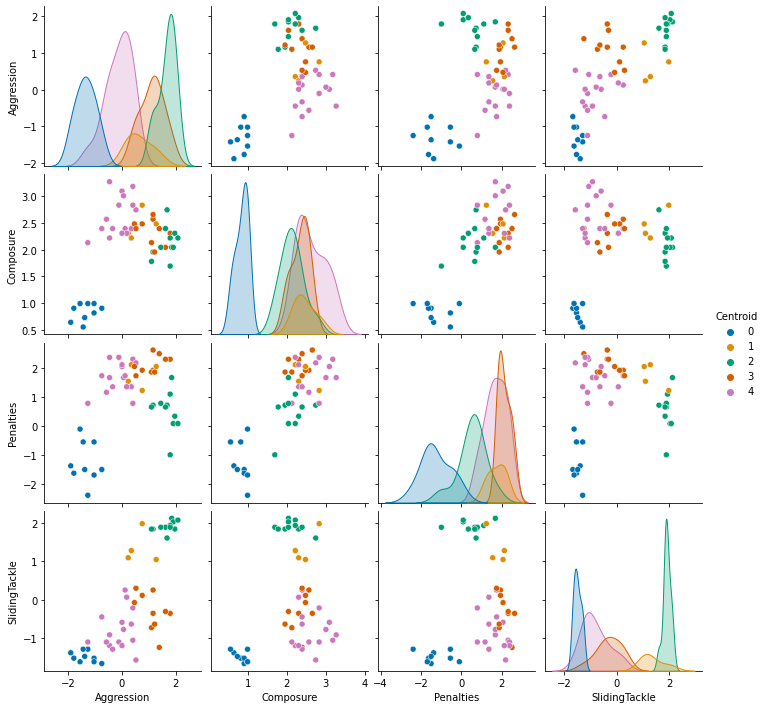

In [12]:
# When plotting, choose a high contrast color pallette (possibly colorblind-friendly :) )
sns.pairplot(new_data, vars=features, hue='Centroid', palette=sns.color_palette("colorblind", K))